In [1]:
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
load_dotenv()
import os
from datetime import datetime, timedelta
from tqdm import tqdm
from processor.processor import Processor as p
from database.adatabase import ADatabase

In [2]:
market = ADatabase("market")
market.connect()
index = market.retrieve("sp500")
market.disconnect()

In [3]:
start = datetime(2020,1,1)
end = datetime.now()

In [4]:
prices = []
date = start
market.connect()
for ticker in tqdm(index["ticker"]):
    try:
        price = market.query("prices",{"ticker":ticker})
        price = p.column_date_processing(price)
        price.sort_values("date",inplace=True)
        prices.append(price)
    except Exception as e:
        print(str(e))
market.disconnect()

 13%|███████████████████████▋                                                                                                                                                                     | 63/503 [00:03<00:20, 21.55it/s]

'date'


 16%|█████████████████████████████▎                                                                                                                                                               | 78/503 [00:03<00:19, 21.75it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:26<00:00, 19.03it/s]

'date'


In [5]:
market_prices = pd.concat(prices)

In [6]:
def calculate_indicators(price, timeframe):
    """Calculate indicators for a single ticker."""
    price = price.sort_values("date")
    price["sma"] = price["adjclose"].rolling(timeframe).mean() / price["adjclose"]
    price["ema"] = price["adjclose"].ewm(span=timeframe, adjust=False).mean() / price["adjclose"]

    delta = price["adjclose"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(timeframe).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(timeframe).mean()
    rs = gain / loss
    price["rsi"] = 100 - (100 / (1 + rs))

    price["std"] = price["adjclose"].rolling(timeframe).std()
    price["bollinger_upper"] = (price["sma"] + 2 * price["std"]) / price["sma"]
    price["bollinger_lower"] = (price["sma"] - 2 * price["std"]) / price["sma"]

    price["pct_change"] = price["adjclose"].pct_change(periods=timeframe)
    price["coev"] = price["adjclose"].rolling(timeframe).std() / price["adjclose"].rolling(timeframe).mean()
    price["year"] = price["date"].dt.year
    price["week"] = [x.week for x in price["date"]]
    price["sell_price"] = price["adjclose"]
    return price.dropna()

In [7]:
signals = ["sma"
           ,"ema","rsi","bollinger_upper","bollinger_lower","pct_change","coev"
          ]
ascendings = [True,False]
timeframes = [5,10,20,60,100]

In [12]:
analysis = []
for timeframe in tqdm(timeframes):
    sim = market_prices.sort_values("date").groupby("ticker").apply(lambda x: calculate_indicators(x,timeframe)).reset_index(drop=True).sort_values("date")
    for signal in signals:
        for ascending in ascendings:
            opportunities = sim[sim["year"]>2020].groupby(["year","week","ticker"]).agg({"date":"last","adjclose":"first","sell_price":"last",signal:"first"}).reset_index()
            trades = opportunities.sort_values(signal,ascending=ascending).groupby(["year","week"]).first().reset_index()
            trades.sort_values("date",inplace=True)
            trades["return"] = trades["sell_price"] / trades["adjclose"]
            trades["pnl"] = trades["return"].cumprod()
            trades["downside"] = trades["pnl"].rolling(100).max() - trades["pnl"]
            analysis.append({
                "timeframe":timeframe,
                "signal":signal,
                "ascending":ascending,
                "pnl":trades["pnl"].iloc[-1],
                "downside":trades["downside"].max(),
                "volatility": trades["return"].std()
            })

  0%|                                                                                                                                                                                                        | 0/5 [00:00<?, ?it/s]C:\Users\eric\AppData\Local\Temp\ipykernel_7348\2064362606.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sim = market_prices.sort_values("date").groupby("ticker").apply(lambda x: calculate_indicators(x,timeframe)).reset_index(drop=True).sort_values("date")
 20%|██████████████████████████████████████▍                                                                                                                                                         | 1/5 [00:11<00:47

In [13]:
a = pd.DataFrame(analysis)
a["risk"] = a["downside"] * a["volatility"]
a["rr"] = a["pnl"] / a["volatility"]

In [17]:
a.sort_values("pnl",ascending=False).head(10)

,timeframe,signal,ascending,pnl,downside,volatility,risk,rr
38,20,pct_change,True,27.353917,2.353341,0.257421,0.605799,106.261429
31,20,ema,False,15.849004,1.771258,0.254766,0.451257,62.209992
17,10,ema,False,8.048602,1.554840,0.069410,0.107921,115.958120
66,100,pct_change,True,7.487985,2.597427,0.072613,0.188608,103.121305
3,5,ema,False,6.712388,1.517584,0.065402,0.099254,102.632052
15,10,sma,False,6.447737,1.739059,0.067856,0.118005,95.021223
10,5,pct_change,True,5.024299,1.593796,0.067714,0.107923,74.198268
29,20,sma,False,4.372981,2.041904,0.078751,0.160803,55.528987
33,20,rsi,False,4.357596,0.515278,0.045148,0.023264,96.518954
1,5,sma,False,4.339527,1.374754,0.064594,0.088801,67.181810


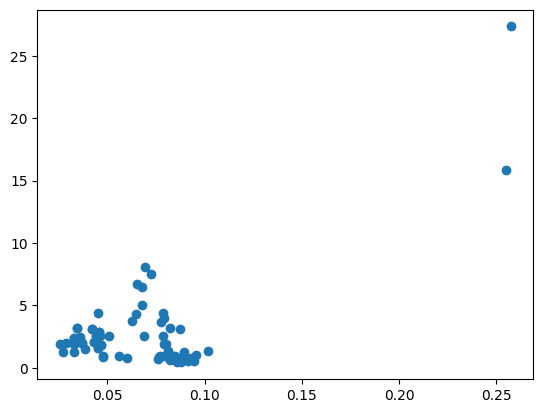

In [16]:
plt.scatter(a["volatility"],a["pnl"])